# Music Genre Classification

### Model Training

We do model training using following models and check the accuracy.
- DNN
- CNN
- LSTM

### Importing required packages

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
from torch.optim import lr_scheduler
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

### Importing data

In [3]:
!conda install -y gdown

Retrieving notices: ...working... done
done
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 23.7.4
  latest version: 24.1.2

Please update conda by running

    $ conda update -n base -c conda-forge conda

Or to minimize the number of packages updated during conda update use

     conda install conda=24.1.2



## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - gdown


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    filelock-3.13.1            |     pyhd8ed1ab_0          15 KB  conda-forge
    gdown-5.1.0                |     pyhd8ed1ab_0          21 KB  conda-forge
    openssl-3.2.1              |       hd590300_1         2.7 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.8 MB

The following NEW packages will be 

In [4]:
!gdown --id 1XzqPHiknJhD5C_QNhQV0ifw-M162iMlR

/opt/conda/lib/python3.10/site-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1XzqPHiknJhD5C_QNhQV0ifw-M162iMlR
From (redirected): https://drive.google.com/uc?id=1XzqPHiknJhD5C_QNhQV0ifw-M162iMlR&confirm=t&uuid=de34ced2-00f7-4c06-97ef-830e51a46202
To: /kaggle/working/mfcc_features.npz
100%|███████████████████████████████████████| 96.0M/96.0M [00:00<00:00, 113MB/s]


In [6]:
mfcc_data = np.load('/kaggle/working/mfcc_features.npz')

In [7]:
X = mfcc_data['X_mfcc']
Y = mfcc_data['Y_mfcc']

### Converting categorical label to numerical values

In [8]:
le = LabelEncoder()
Y = le.fit_transform(Y)

In [9]:
mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(f'Mapping = {mapping}')

Mapping = {'blues': 0, 'classical': 1, 'country': 2, 'disco': 3, 'hiphop': 4, 'jazz': 5, 'metal': 6, 'pop': 7, 'reggae': 8, 'rock': 9}


#### Splitting data into train, test, valid

In [10]:
X_train_valid, X_test, y_train_valid, y_test = train_test_split(X, Y, test_size=0.1, random_state=42, stratify=Y)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid, y_train_valid, test_size=0.1, random_state=42, stratify=y_train_valid)

In [11]:
print(f'Shape of X_train = {X_train.shape}')
print(f'Shape of y_train = {y_train.shape}')
print(f'Shape of X_valid = {X_valid.shape}')
print(f'Shape of y_valid = {y_valid.shape}')
print(f'Shape of X_test = {X_test.shape}')
print(f'Shape of y_test = {y_test.shape}')

Shape of X_train = (2430, 20, 431)
Shape of y_train = (2430,)
Shape of X_valid = (270, 20, 431)
Shape of y_valid = (270,)
Shape of X_test = (300, 20, 431)
Shape of y_test = (300,)


### Standardization

In [12]:
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)
X_train = (X_train - mean)/std
X_test = (X_test - mean)/std
X_valid = (X_valid - mean)/std

Making X consistent with LSTM input

In [13]:
X_train = np.transpose(X_train, (0, 2, 1))
X_test = np.transpose(X_test, (0, 2, 1))
X_valid = np.transpose(X_valid, (0, 2, 1))

In [14]:
print(f'Shape of X_train = {X_train.shape}')
print(f'Shape of y_train = {y_train.shape}')
print(f'Shape of X_valid = {X_valid.shape}')
print(f'Shape of y_valid = {y_valid.shape}')
print(f'Shape of X_test = {X_test.shape}')
print(f'Shape of y_test = {y_test.shape}')

Shape of X_train = (2430, 431, 20)
Shape of y_train = (2430,)
Shape of X_valid = (270, 431, 20)
Shape of y_valid = (270,)
Shape of X_test = (300, 431, 20)
Shape of y_test = (300,)


#### Creating train and valid dataloader

In [15]:
train_data = torch.utils.data.TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
train_loader = torch.utils.data.DataLoader(dataset=train_data,
                                           batch_size = 16,
                                           shuffle = True)

valid_data = torch.utils.data.TensorDataset(torch.tensor(X_valid), torch.tensor(y_valid))
valid_loader = torch.utils.data.DataLoader(dataset=valid_data,
                                           batch_size = 16,
                                           shuffle = True)

## Models

### Training

In [28]:
def training(model, model_name, loss_fn, optimizer, scheduler, train_data_loader, valid_data_loader, num_epochs = 25, patience = 5):
    max_acc = 0.0
    count = 0
    history = []
    for epoch in tqdm(range(num_epochs)):
        model.train()
        train_loss = 0.0
        train_acc = 0.0 
        
        valid_loss = 0.0
        valid_acc = 0.0
        for _, (inputs, labels) in enumerate(train_data_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            y_preds = model(inputs)
            loss = loss_fn(y_preds, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()*len(inputs)
            correct_counts = (torch.argmax(y_preds.data, 1) == labels).float().sum().item()
            train_acc += correct_counts
        
        with torch.no_grad():
            model.eval()
            for _, (inputs, labels) in enumerate(valid_data_loader):
                inputs = inputs.to(device)
                labels = labels.to(device)
                y_preds = model(inputs)
                loss = loss_fn(y_preds, labels)
                valid_loss += loss.item()*len(inputs)
                correct_counts = (torch.argmax(y_preds.data, 1) == labels).float().sum().item()
                valid_acc += correct_counts
        
        train_loss = train_loss/len(train_data_loader.dataset)
        train_acc = train_acc/len(train_data_loader.dataset)
        
        valid_loss = valid_loss/len(valid_data_loader.dataset)
        valid_acc = valid_acc/len(valid_data_loader.dataset)
        
        history.append([train_acc, train_loss, valid_acc, valid_loss]) 
        print(f'Epoch No. {epoch+1}')
        print(f'Training Accuracy = {train_acc:.4f}, Loss = {train_loss:.4f}')
        print(f'Validation Accuracy = {valid_acc:.4f}, Loss = {valid_loss:.4f}')
        torch.save(model.state_dict(), model_name + '_last_epoch.pt')
        
        scheduler.step(valid_loss)
        
        if (valid_acc > max_acc):
            count = 0 
            max_acc = valid_acc 
            torch.save(model.state_dict(), model_name + '_best_model.pt')
        
        else:
            count += 1
            if (count >= patience):
                print(f'Early stop at Epoch Number. {epoch + 1}')
                break 
        
    return model, history

### Accuracy for test data

In [18]:
test_data = torch.utils.data.TensorDataset(torch.tensor(X_test), torch.tensor(y_test))
test_loader = torch.utils.data.DataLoader(dataset=test_data,
                                           batch_size = 16,
                                           shuffle = True)

In [19]:
def get_accuracy(trained_model, loss_fn, test_data_loader):
    test_loss = 0.0
    test_acc = 0.0
    with torch.no_grad():
        trained_model.eval()
        for _, (inputs, labels) in enumerate(test_data_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            y_preds = trained_model(inputs)
            loss = loss_fn(y_preds, labels)
            test_loss += loss.item()*len(inputs)
            correct_counts = (torch.argmax(y_preds.data, 1) == labels).float().sum().item()
            test_acc += correct_counts
    test_loss = test_loss/len(test_data_loader.dataset)
    test_acc = test_acc/len(test_data_loader.dataset)
    print(f'Loss for test set = {test_loss:.4f}')
    print(f'Accuracy for test set = {test_acc:.4f}')
    return test_loss, test_acc

In [20]:
def post_training(trained_model, loss_fn, test_loader, history, model_name):
    test_loss, test_acc = get_accuracy(trained_model, loss_fn, test_loader)
    history_np = np.array(history)
    fig, axes = plt.subplots(1, 2, figsize = (12, 4))
    epochs_list = np.arange(1, len(history_np)+1)
    axes[0].plot(epochs_list, history_np[:, 0], label = "Training Accuracy", marker = '.')
    axes[0].plot(epochs_list, history_np[:, 2], label = "Validation Accuracy", marker = '.')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()

    axes[1].plot(epochs_list, history_np[:, 1], label = "Training Loss", marker = '.')
    axes[1].plot(epochs_list, history_np[:, 3], label = "Validation Loss", marker = '.')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Loss')
    axes[1].legend()

    fig.suptitle(f'Training for {model_name}')
    plt.show()
    return test_loss, test_acc

### 1. DNN

In [21]:
input_size = X_train.shape[1] * X_train.shape[2]
print(f'Input Size = {input_size}')

Input Size = 8620


In [23]:
model_name = 'DNN'
model_1 = nn.Sequential(
    nn.Flatten(),
    nn.Linear(input_size, 2048),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(2048, 1024),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 10)
)
learning_rate = 0.001
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_1.parameters(), lr = learning_rate)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
model_1.to(device)
trained_model1 , history_model1 = training(model_1, 'DNN', loss_fn, optimizer, scheduler, train_loader, valid_loader, 200, 50)

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch No. 1
Training Accuracy = 0.3210, Loss = 2.1233
Validation Accuracy = 0.4333, Loss = 1.4479


  0%|          | 1/200 [00:01<05:56,  1.79s/it]

Epoch No. 2
Training Accuracy = 0.4177, Loss = 1.7704
Validation Accuracy = 0.4630, Loss = 1.5400


  1%|          | 2/200 [00:03<05:26,  1.65s/it]

Epoch No. 3
Training Accuracy = 0.4329, Loss = 1.6739
Validation Accuracy = 0.5111, Loss = 1.4045


  2%|▏         | 3/200 [00:05<05:33,  1.69s/it]

Epoch No. 4
Training Accuracy = 0.4630, Loss = 1.6300
Validation Accuracy = 0.5037, Loss = 1.5021


  2%|▎         | 5/200 [00:09<06:18,  1.94s/it]

Epoch No. 5
Training Accuracy = 0.4782, Loss = 1.6045
Validation Accuracy = 0.4778, Loss = 1.6332


  3%|▎         | 6/200 [00:11<05:49,  1.80s/it]

Epoch No. 6
Training Accuracy = 0.4868, Loss = 1.6081
Validation Accuracy = 0.5111, Loss = 1.4534
Epoch No. 7
Training Accuracy = 0.4823, Loss = 1.6378
Validation Accuracy = 0.5222, Loss = 1.4085


  4%|▍         | 8/200 [00:14<05:23,  1.69s/it]

Epoch No. 8
Training Accuracy = 0.5300, Loss = 1.4725
Validation Accuracy = 0.5593, Loss = 1.5427


  4%|▍         | 9/200 [00:15<05:12,  1.64s/it]

Epoch No. 9
Training Accuracy = 0.5206, Loss = 1.4708
Validation Accuracy = 0.5037, Loss = 1.5076


  5%|▌         | 10/200 [00:17<05:05,  1.61s/it]

Epoch No. 10
Training Accuracy = 0.5449, Loss = 1.3690
Validation Accuracy = 0.5000, Loss = 1.6612
Epoch No. 11
Training Accuracy = 0.5588, Loss = 1.4310
Validation Accuracy = 0.5444, Loss = 1.4014


  6%|▌         | 11/200 [00:19<05:38,  1.79s/it]

Epoch No. 12
Training Accuracy = 0.5597, Loss = 1.3878
Validation Accuracy = 0.5333, Loss = 1.4520


  6%|▋         | 13/200 [00:22<05:11,  1.67s/it]

Epoch No. 13
Training Accuracy = 0.5757, Loss = 1.3954
Validation Accuracy = 0.5037, Loss = 1.5246
Epoch No. 14
Training Accuracy = 0.5444, Loss = 1.4522
Validation Accuracy = 0.5370, Loss = 1.5781


  8%|▊         | 15/200 [00:25<05:01,  1.63s/it]

Epoch No. 15
Training Accuracy = 0.5852, Loss = 1.3445
Validation Accuracy = 0.5556, Loss = 1.4071


  8%|▊         | 16/200 [00:27<04:54,  1.60s/it]

Epoch No. 16
Training Accuracy = 0.6004, Loss = 1.2811
Validation Accuracy = 0.5667, Loss = 1.4993


  8%|▊         | 17/200 [00:28<04:49,  1.58s/it]

Epoch No. 17
Training Accuracy = 0.5601, Loss = 1.3985
Validation Accuracy = 0.5444, Loss = 1.5229
Epoch No. 18
Training Accuracy = 0.5951, Loss = 1.2849
Validation Accuracy = 0.5630, Loss = 1.5310


 10%|▉         | 19/200 [00:32<04:54,  1.63s/it]

Epoch No. 19
Training Accuracy = 0.5918, Loss = 1.2581
Validation Accuracy = 0.5259, Loss = 1.7481


 10%|█         | 20/200 [00:33<04:48,  1.60s/it]

Epoch No. 20
Training Accuracy = 0.6144, Loss = 1.1898
Validation Accuracy = 0.5407, Loss = 1.5834
Epoch No. 21
Training Accuracy = 0.6144, Loss = 1.2154
Validation Accuracy = 0.5000, Loss = 1.6563


 11%|█         | 22/200 [00:37<04:45,  1.60s/it]

Epoch No. 22
Training Accuracy = 0.6021, Loss = 1.1690
Validation Accuracy = 0.5815, Loss = 1.6475


 12%|█▏        | 23/200 [00:38<04:39,  1.58s/it]

Epoch No. 23
Training Accuracy = 0.6436, Loss = 1.0492
Validation Accuracy = 0.5704, Loss = 1.6340


 12%|█▏        | 24/200 [00:40<04:36,  1.57s/it]

Epoch No. 24
Training Accuracy = 0.6646, Loss = 0.9682
Validation Accuracy = 0.5593, Loss = 1.6014
Epoch No. 25
Training Accuracy = 0.6757, Loss = 0.9338
Validation Accuracy = 0.5852, Loss = 1.5406


 13%|█▎        | 26/200 [00:43<04:30,  1.56s/it]

Epoch No. 26
Training Accuracy = 0.6840, Loss = 0.8820
Validation Accuracy = 0.5704, Loss = 1.5961


 14%|█▎        | 27/200 [00:44<04:28,  1.55s/it]

Epoch No. 27
Training Accuracy = 0.6979, Loss = 0.8646
Validation Accuracy = 0.5889, Loss = 1.5641


 14%|█▍        | 28/200 [00:46<04:26,  1.55s/it]

Epoch No. 28
Training Accuracy = 0.7193, Loss = 0.8105
Validation Accuracy = 0.5741, Loss = 1.5609


 14%|█▍        | 29/200 [00:47<04:23,  1.54s/it]

Epoch No. 29
Training Accuracy = 0.7169, Loss = 0.8241
Validation Accuracy = 0.5926, Loss = 1.5468


 15%|█▌        | 30/200 [00:49<04:21,  1.54s/it]

Epoch No. 30
Training Accuracy = 0.7008, Loss = 0.7993
Validation Accuracy = 0.5889, Loss = 1.6146


 16%|█▌        | 31/200 [00:50<04:22,  1.55s/it]

Epoch No. 31
Training Accuracy = 0.7235, Loss = 0.7737
Validation Accuracy = 0.5852, Loss = 1.6013


 16%|█▌        | 32/200 [00:52<04:20,  1.55s/it]

Epoch No. 32
Training Accuracy = 0.7313, Loss = 0.7579
Validation Accuracy = 0.5926, Loss = 1.5887
Epoch No. 33
Training Accuracy = 0.7395, Loss = 0.7324
Validation Accuracy = 0.5889, Loss = 1.6528


 17%|█▋        | 34/200 [00:55<04:26,  1.61s/it]

Epoch No. 34
Training Accuracy = 0.7424, Loss = 0.7380
Validation Accuracy = 0.5889, Loss = 1.6538


 18%|█▊        | 35/200 [00:57<04:22,  1.59s/it]

Epoch No. 35
Training Accuracy = 0.7416, Loss = 0.7366
Validation Accuracy = 0.5926, Loss = 1.6471
Epoch No. 36
Training Accuracy = 0.7477, Loss = 0.6987
Validation Accuracy = 0.5889, Loss = 1.6414


 18%|█▊        | 37/200 [01:00<04:21,  1.60s/it]

Epoch No. 37
Training Accuracy = 0.7519, Loss = 0.7084
Validation Accuracy = 0.5889, Loss = 1.6436
Epoch No. 38
Training Accuracy = 0.7531, Loss = 0.7010
Validation Accuracy = 0.5889, Loss = 1.6448


 19%|█▉        | 38/200 [01:02<04:17,  1.59s/it]

Epoch No. 39
Training Accuracy = 0.7412, Loss = 0.7211
Validation Accuracy = 0.5852, Loss = 1.6492


 20%|█▉        | 39/200 [01:03<04:14,  1.58s/it]

Epoch No. 40
Training Accuracy = 0.7490, Loss = 0.7162
Validation Accuracy = 0.5926, Loss = 1.6475


 20%|██        | 41/200 [01:07<04:25,  1.67s/it]

Epoch No. 41
Training Accuracy = 0.7424, Loss = 0.7062
Validation Accuracy = 0.5889, Loss = 1.6501


 21%|██        | 42/200 [01:08<04:17,  1.63s/it]

Epoch No. 42
Training Accuracy = 0.7412, Loss = 0.7142
Validation Accuracy = 0.5889, Loss = 1.6490
Epoch No. 43
Training Accuracy = 0.7440, Loss = 0.6910
Validation Accuracy = 0.5852, Loss = 1.6470


 22%|██▏       | 44/200 [01:12<04:22,  1.68s/it]

Epoch No. 44
Training Accuracy = 0.7473, Loss = 0.6957
Validation Accuracy = 0.5852, Loss = 1.6459
Epoch No. 45
Training Accuracy = 0.7502, Loss = 0.6976
Validation Accuracy = 0.5852, Loss = 1.6455


 22%|██▎       | 45/200 [01:14<04:14,  1.64s/it]

Epoch No. 46
Training Accuracy = 0.7444, Loss = 0.6895
Validation Accuracy = 0.5852, Loss = 1.6456


 24%|██▎       | 47/200 [01:17<04:07,  1.62s/it]

Epoch No. 47
Training Accuracy = 0.7519, Loss = 0.7108
Validation Accuracy = 0.5815, Loss = 1.6473


 24%|██▍       | 48/200 [01:18<04:02,  1.60s/it]

Epoch No. 48
Training Accuracy = 0.7510, Loss = 0.6821
Validation Accuracy = 0.5778, Loss = 1.6474
Epoch No. 49
Training Accuracy = 0.7473, Loss = 0.6976
Validation Accuracy = 0.5815, Loss = 1.6477


 25%|██▌       | 50/200 [01:21<03:56,  1.58s/it]

Epoch No. 50
Training Accuracy = 0.7621, Loss = 0.6768
Validation Accuracy = 0.5778, Loss = 1.6481


 26%|██▌       | 51/200 [01:23<03:53,  1.57s/it]

Epoch No. 51
Training Accuracy = 0.7514, Loss = 0.6962
Validation Accuracy = 0.5778, Loss = 1.6478


 26%|██▌       | 52/200 [01:25<03:50,  1.56s/it]

Epoch No. 52
Training Accuracy = 0.7523, Loss = 0.6944
Validation Accuracy = 0.5778, Loss = 1.6472


 26%|██▋       | 53/200 [01:26<03:48,  1.55s/it]

Epoch No. 53
Training Accuracy = 0.7469, Loss = 0.7122
Validation Accuracy = 0.5815, Loss = 1.6480
Epoch No. 54
Training Accuracy = 0.7527, Loss = 0.6900
Validation Accuracy = 0.5815, Loss = 1.6485


 28%|██▊       | 55/200 [01:30<04:01,  1.67s/it]

Epoch No. 55
Training Accuracy = 0.7539, Loss = 0.6732
Validation Accuracy = 0.5815, Loss = 1.6481


 28%|██▊       | 56/200 [01:31<03:54,  1.63s/it]

Epoch No. 56
Training Accuracy = 0.7420, Loss = 0.7125
Validation Accuracy = 0.5815, Loss = 1.6481
Epoch No. 57
Training Accuracy = 0.7477, Loss = 0.7090
Validation Accuracy = 0.5815, Loss = 1.6481


 29%|██▉       | 58/200 [01:34<03:48,  1.61s/it]

Epoch No. 58
Training Accuracy = 0.7551, Loss = 0.6842
Validation Accuracy = 0.5815, Loss = 1.6481


 30%|██▉       | 59/200 [01:36<03:44,  1.59s/it]

Epoch No. 59
Training Accuracy = 0.7436, Loss = 0.7150
Validation Accuracy = 0.5815, Loss = 1.6481


 30%|███       | 60/200 [01:38<03:40,  1.58s/it]

Epoch No. 60
Training Accuracy = 0.7440, Loss = 0.7102
Validation Accuracy = 0.5815, Loss = 1.6481


 30%|███       | 60/200 [01:39<03:52,  1.66s/it]

Epoch No. 61
Training Accuracy = 0.7531, Loss = 0.6870
Validation Accuracy = 0.5815, Loss = 1.6481
Early stop at Epoch Number. 61


Loss for test set = 1.5752
Accuracy for test set = 0.6033


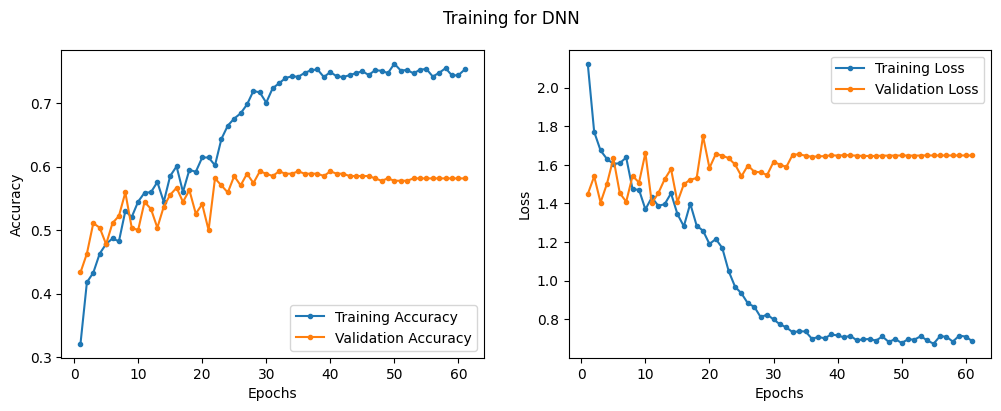

In [24]:
test_loss_1, test_acc_1 = post_training(trained_model1, loss_fn, test_loader, history_model1, 'DNN')

### 2. CNN

### Creating train and valid dataloaders

CNN requires an extra dimension to be added to the data to indicate the channel, we need it for convolution operation

In [25]:
X_train_cnn = np.expand_dims(X_train, 1)
X_valid_cnn = np.expand_dims(X_valid, 1)
train_data_cnn = torch.utils.data.TensorDataset(torch.tensor(X_train_cnn), torch.tensor(y_train))
train_loader_cnn = torch.utils.data.DataLoader(dataset=train_data_cnn,
                                           batch_size = 16,
                                           shuffle = True)

valid_data_cnn = torch.utils.data.TensorDataset(torch.tensor(X_valid_cnn), torch.tensor(y_valid))
valid_loader_cnn = torch.utils.data.DataLoader(dataset=valid_data_cnn,
                                           batch_size = 16,
                                           shuffle = True)

In [26]:
class CNN_music(nn.Module):
    def __init__(self) :
        super(CNN_music, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=256,
                      kernel_size=3,   padding='same'),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256)
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256,
                      kernel_size=3,   padding='same'),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256)
        ) 

        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256,
                      kernel_size=2,   padding=2),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=1),
            nn.BatchNorm2d(256)
        )

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Flatten(),
            nn.Linear(256 * 280, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 10)
        )
        
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.fc(x)
        return x

In [29]:
model_2 = CNN_music()
learning_rate = 0.001
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_2.parameters(), lr = learning_rate)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
model_2.to(device)
trained_model_2 , history_model_2 = training(model_2, 'CNN', loss_fn, optimizer, scheduler, train_loader_cnn, valid_loader_cnn, 100, 10)

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch No. 1
Training Accuracy = 0.3802, Loss = 4.0272
Validation Accuracy = 0.5037, Loss = 1.3281


  0%|          | 1/200 [00:08<27:42,  8.36s/it]

Epoch No. 2
Training Accuracy = 0.5457, Loss = 1.2562
Validation Accuracy = 0.6000, Loss = 1.1734


  1%|          | 2/200 [00:16<27:32,  8.34s/it]

Epoch No. 3
Training Accuracy = 0.6374, Loss = 1.0210
Validation Accuracy = 0.5852, Loss = 1.0840


  2%|▏         | 3/200 [00:24<26:55,  8.20s/it]

Epoch No. 4
Training Accuracy = 0.7119, Loss = 0.8005
Validation Accuracy = 0.6778, Loss = 1.0383


  2%|▏         | 4/200 [00:33<27:06,  8.30s/it]

Epoch No. 5
Training Accuracy = 0.7626, Loss = 0.6772
Validation Accuracy = 0.6704, Loss = 1.0358


  2%|▎         | 5/200 [00:41<26:48,  8.25s/it]

Epoch No. 6
Training Accuracy = 0.7975, Loss = 0.5748
Validation Accuracy = 0.6407, Loss = 1.1438


  3%|▎         | 6/200 [00:49<26:35,  8.22s/it]

Epoch No. 7
Training Accuracy = 0.8436, Loss = 0.4488
Validation Accuracy = 0.6630, Loss = 1.1389


  4%|▎         | 7/200 [00:57<26:21,  8.20s/it]

Epoch No. 8
Training Accuracy = 0.8778, Loss = 0.3562
Validation Accuracy = 0.7222, Loss = 0.9964


  4%|▍         | 8/200 [01:06<26:28,  8.27s/it]

Epoch No. 9
Training Accuracy = 0.9107, Loss = 0.2412
Validation Accuracy = 0.6815, Loss = 1.2946


  4%|▍         | 9/200 [01:14<26:07,  8.21s/it]

Epoch No. 10
Training Accuracy = 0.9066, Loss = 0.2950
Validation Accuracy = 0.6889, Loss = 1.3300


  5%|▌         | 10/200 [01:22<25:50,  8.16s/it]

Epoch No. 11
Training Accuracy = 0.9346, Loss = 0.2058
Validation Accuracy = 0.7148, Loss = 1.3625


  6%|▌         | 11/200 [01:30<25:35,  8.12s/it]

Epoch No. 12
Training Accuracy = 0.9123, Loss = 0.2725
Validation Accuracy = 0.6889, Loss = 1.6375


  6%|▌         | 12/200 [01:38<25:22,  8.10s/it]

Epoch No. 13
Training Accuracy = 0.9432, Loss = 0.1695
Validation Accuracy = 0.6852, Loss = 1.4508


  6%|▋         | 13/200 [01:46<25:12,  8.09s/it]

Epoch No. 14
Training Accuracy = 0.9498, Loss = 0.1394
Validation Accuracy = 0.7222, Loss = 1.3818


  7%|▋         | 14/200 [01:54<25:03,  8.09s/it]

Epoch No. 15
Training Accuracy = 0.9675, Loss = 0.0917
Validation Accuracy = 0.6778, Loss = 1.7626


  8%|▊         | 15/200 [02:02<24:55,  8.08s/it]

Epoch No. 16
Training Accuracy = 0.9724, Loss = 0.0850
Validation Accuracy = 0.6889, Loss = 1.6455


  8%|▊         | 16/200 [02:10<24:47,  8.08s/it]

Epoch No. 17
Training Accuracy = 0.9621, Loss = 0.1154
Validation Accuracy = 0.6667, Loss = 1.8937


  8%|▊         | 17/200 [02:18<24:39,  8.08s/it]

Epoch No. 18
Training Accuracy = 0.9506, Loss = 0.1801
Validation Accuracy = 0.6667, Loss = 2.4518


  9%|▉         | 18/200 [02:26<24:30,  8.08s/it]

Epoch No. 19
Training Accuracy = 0.9621, Loss = 0.1163
Validation Accuracy = 0.7222, Loss = 1.6062


 10%|▉         | 19/200 [02:34<24:22,  8.08s/it]

Epoch No. 20
Training Accuracy = 0.9872, Loss = 0.0359
Validation Accuracy = 0.7444, Loss = 1.6194


 10%|█         | 20/200 [02:43<24:35,  8.20s/it]

Epoch No. 21
Training Accuracy = 0.9947, Loss = 0.0168
Validation Accuracy = 0.7407, Loss = 1.5172


 10%|█         | 21/200 [02:51<24:20,  8.16s/it]

Epoch No. 22
Training Accuracy = 0.9938, Loss = 0.0173
Validation Accuracy = 0.7481, Loss = 1.5877


 11%|█         | 22/200 [02:59<24:26,  8.24s/it]

Epoch No. 23
Training Accuracy = 0.9963, Loss = 0.0119
Validation Accuracy = 0.7333, Loss = 1.6262


 12%|█▏        | 23/200 [03:07<24:08,  8.18s/it]

Epoch No. 24
Training Accuracy = 0.9959, Loss = 0.0125
Validation Accuracy = 0.7407, Loss = 1.6420


 12%|█▏        | 24/200 [03:15<23:53,  8.15s/it]

Epoch No. 25
Training Accuracy = 0.9967, Loss = 0.0096
Validation Accuracy = 0.7444, Loss = 1.5440


 12%|█▎        | 25/200 [03:23<23:41,  8.12s/it]

Epoch No. 26
Training Accuracy = 0.9971, Loss = 0.0078
Validation Accuracy = 0.7370, Loss = 1.6056


 13%|█▎        | 26/200 [03:32<23:30,  8.11s/it]

Epoch No. 27
Training Accuracy = 0.9967, Loss = 0.0108
Validation Accuracy = 0.7370, Loss = 1.5919


 14%|█▎        | 27/200 [03:40<23:20,  8.10s/it]

Epoch No. 28
Training Accuracy = 0.9967, Loss = 0.0077
Validation Accuracy = 0.7296, Loss = 1.6821


 14%|█▍        | 28/200 [03:48<23:11,  8.09s/it]

Epoch No. 29
Training Accuracy = 0.9979, Loss = 0.0066
Validation Accuracy = 0.7333, Loss = 1.6563


 14%|█▍        | 29/200 [03:56<23:02,  8.08s/it]

Epoch No. 30
Training Accuracy = 0.9967, Loss = 0.0074
Validation Accuracy = 0.7444, Loss = 1.6336


 15%|█▌        | 30/200 [04:04<22:53,  8.08s/it]

Epoch No. 31
Training Accuracy = 0.9984, Loss = 0.0068
Validation Accuracy = 0.7407, Loss = 1.6889


 16%|█▌        | 31/200 [04:12<22:44,  8.07s/it]

Epoch No. 32
Training Accuracy = 0.9984, Loss = 0.0059
Validation Accuracy = 0.7370, Loss = 1.6078


 16%|█▌        | 32/200 [04:20<22:35,  8.07s/it]

Epoch No. 33
Training Accuracy = 0.9979, Loss = 0.0068
Validation Accuracy = 0.7444, Loss = 1.6103


 16%|█▋        | 33/200 [04:28<22:27,  8.07s/it]

Epoch No. 34
Training Accuracy = 0.9979, Loss = 0.0056
Validation Accuracy = 0.7407, Loss = 1.5879


 17%|█▋        | 34/200 [04:36<22:19,  8.07s/it]

Epoch No. 35
Training Accuracy = 0.9979, Loss = 0.0074
Validation Accuracy = 0.7370, Loss = 1.6581


 18%|█▊        | 35/200 [04:44<22:11,  8.07s/it]

Epoch No. 36
Training Accuracy = 0.9979, Loss = 0.0067
Validation Accuracy = 0.7370, Loss = 1.6605


 18%|█▊        | 36/200 [04:52<22:02,  8.07s/it]

Epoch No. 37
Training Accuracy = 0.9988, Loss = 0.0054
Validation Accuracy = 0.7407, Loss = 1.6087


 18%|█▊        | 37/200 [05:00<21:55,  8.07s/it]

Epoch No. 38
Training Accuracy = 0.9975, Loss = 0.0061
Validation Accuracy = 0.7444, Loss = 1.6344


 19%|█▉        | 38/200 [05:08<21:47,  8.07s/it]

Epoch No. 39
Training Accuracy = 0.9979, Loss = 0.0067
Validation Accuracy = 0.7481, Loss = 1.6776


 20%|█▉        | 39/200 [05:16<21:39,  8.07s/it]

Epoch No. 40
Training Accuracy = 0.9979, Loss = 0.0061
Validation Accuracy = 0.7481, Loss = 1.5825


 20%|██        | 40/200 [05:25<21:31,  8.07s/it]

Epoch No. 41
Training Accuracy = 0.9979, Loss = 0.0071
Validation Accuracy = 0.7370, Loss = 1.6264


 20%|██        | 41/200 [05:33<21:23,  8.07s/it]

Epoch No. 42
Training Accuracy = 0.9984, Loss = 0.0051
Validation Accuracy = 0.7407, Loss = 1.6245


 21%|██        | 42/200 [05:41<21:15,  8.07s/it]

Epoch No. 43
Training Accuracy = 0.9984, Loss = 0.0048
Validation Accuracy = 0.7444, Loss = 1.6243


 22%|██▏       | 43/200 [05:49<21:07,  8.07s/it]

Epoch No. 44
Training Accuracy = 0.9975, Loss = 0.0082
Validation Accuracy = 0.7407, Loss = 1.5954


 22%|██▏       | 44/200 [05:57<20:59,  8.07s/it]

Epoch No. 45
Training Accuracy = 0.9975, Loss = 0.0064
Validation Accuracy = 0.7444, Loss = 1.6512


 22%|██▎       | 45/200 [06:05<20:51,  8.07s/it]

Epoch No. 46
Training Accuracy = 0.9984, Loss = 0.0059
Validation Accuracy = 0.7481, Loss = 1.6430


 23%|██▎       | 46/200 [06:13<20:43,  8.07s/it]

Epoch No. 47
Training Accuracy = 0.9984, Loss = 0.0063
Validation Accuracy = 0.7593, Loss = 1.5853


 24%|██▎       | 47/200 [06:21<20:51,  8.18s/it]

Epoch No. 48
Training Accuracy = 0.9979, Loss = 0.0066
Validation Accuracy = 0.7407, Loss = 1.6319


 24%|██▍       | 48/200 [06:29<20:38,  8.15s/it]

Epoch No. 49
Training Accuracy = 0.9984, Loss = 0.0054
Validation Accuracy = 0.7370, Loss = 1.6279


 24%|██▍       | 49/200 [06:38<20:26,  8.12s/it]

Epoch No. 50
Training Accuracy = 0.9984, Loss = 0.0050
Validation Accuracy = 0.7444, Loss = 1.6098


 25%|██▌       | 50/200 [06:46<20:15,  8.11s/it]

Epoch No. 51
Training Accuracy = 0.9979, Loss = 0.0054
Validation Accuracy = 0.7407, Loss = 1.6197


 26%|██▌       | 51/200 [06:54<20:05,  8.09s/it]

Epoch No. 52
Training Accuracy = 0.9984, Loss = 0.0052
Validation Accuracy = 0.7407, Loss = 1.6263


 26%|██▌       | 52/200 [07:02<19:56,  8.09s/it]

Epoch No. 53
Training Accuracy = 0.9984, Loss = 0.0050
Validation Accuracy = 0.7444, Loss = 1.6188


 26%|██▋       | 53/200 [07:10<19:48,  8.08s/it]

Epoch No. 54
Training Accuracy = 0.9971, Loss = 0.0061
Validation Accuracy = 0.7370, Loss = 1.6170


 27%|██▋       | 54/200 [07:18<19:40,  8.08s/it]

Epoch No. 55
Training Accuracy = 0.9979, Loss = 0.0058
Validation Accuracy = 0.7370, Loss = 1.6221


 28%|██▊       | 55/200 [07:26<19:31,  8.08s/it]

Epoch No. 56
Training Accuracy = 0.9984, Loss = 0.0051
Validation Accuracy = 0.7481, Loss = 1.6767


 28%|██▊       | 56/200 [07:34<19:23,  8.08s/it]

Epoch No. 57
Training Accuracy = 0.9979, Loss = 0.0074
Validation Accuracy = 0.7444, Loss = 1.6760


 28%|██▊       | 57/200 [07:42<19:14,  8.07s/it]

Epoch No. 58
Training Accuracy = 0.9975, Loss = 0.0054
Validation Accuracy = 0.7370, Loss = 1.5572


 29%|██▉       | 58/200 [07:50<19:06,  8.07s/it]

Epoch No. 59
Training Accuracy = 0.9984, Loss = 0.0049
Validation Accuracy = 0.7444, Loss = 1.6312


 30%|██▉       | 59/200 [07:58<18:57,  8.07s/it]

Epoch No. 60
Training Accuracy = 0.9988, Loss = 0.0045
Validation Accuracy = 0.7407, Loss = 1.6679


 30%|███       | 60/200 [08:06<18:50,  8.08s/it]

Epoch No. 61
Training Accuracy = 0.9979, Loss = 0.0061
Validation Accuracy = 0.7370, Loss = 1.6525


 30%|███       | 61/200 [08:14<18:42,  8.08s/it]

Epoch No. 62
Training Accuracy = 0.9988, Loss = 0.0048
Validation Accuracy = 0.7370, Loss = 1.6684


 31%|███       | 62/200 [08:22<18:34,  8.07s/it]

Epoch No. 63
Training Accuracy = 0.9984, Loss = 0.0048
Validation Accuracy = 0.7444, Loss = 1.5947


 32%|███▏      | 63/200 [08:31<18:25,  8.07s/it]

Epoch No. 64
Training Accuracy = 0.9979, Loss = 0.0055
Validation Accuracy = 0.7444, Loss = 1.5990


 32%|███▏      | 64/200 [08:39<18:17,  8.07s/it]

Epoch No. 65
Training Accuracy = 0.9984, Loss = 0.0054
Validation Accuracy = 0.7407, Loss = 1.6549


 32%|███▎      | 65/200 [08:47<18:09,  8.07s/it]

Epoch No. 66
Training Accuracy = 0.9984, Loss = 0.0059
Validation Accuracy = 0.7370, Loss = 1.6068


 33%|███▎      | 66/200 [08:55<18:01,  8.07s/it]

Epoch No. 67
Training Accuracy = 0.9984, Loss = 0.0052
Validation Accuracy = 0.7370, Loss = 1.6335


 34%|███▎      | 67/200 [09:03<17:54,  8.08s/it]

Epoch No. 68
Training Accuracy = 0.9984, Loss = 0.0070
Validation Accuracy = 0.7519, Loss = 1.6709


 34%|███▍      | 68/200 [09:11<17:46,  8.08s/it]

Epoch No. 69
Training Accuracy = 0.9988, Loss = 0.0050
Validation Accuracy = 0.7370, Loss = 1.6254


 34%|███▍      | 69/200 [09:19<17:38,  8.08s/it]

Epoch No. 70
Training Accuracy = 0.9988, Loss = 0.0049
Validation Accuracy = 0.7407, Loss = 1.6290


 35%|███▌      | 70/200 [09:27<17:30,  8.08s/it]

Epoch No. 71
Training Accuracy = 0.9979, Loss = 0.0061
Validation Accuracy = 0.7370, Loss = 1.7044


 36%|███▌      | 71/200 [09:35<17:22,  8.08s/it]

Epoch No. 72
Training Accuracy = 0.9979, Loss = 0.0062
Validation Accuracy = 0.7481, Loss = 1.6637


 36%|███▌      | 72/200 [09:43<17:14,  8.08s/it]

Epoch No. 73
Training Accuracy = 0.9984, Loss = 0.0050
Validation Accuracy = 0.7444, Loss = 1.6422


 36%|███▋      | 73/200 [09:51<17:05,  8.08s/it]

Epoch No. 74
Training Accuracy = 0.9984, Loss = 0.0051
Validation Accuracy = 0.7370, Loss = 1.6322


 37%|███▋      | 74/200 [09:59<16:57,  8.08s/it]

Epoch No. 75
Training Accuracy = 0.9975, Loss = 0.0056
Validation Accuracy = 0.7444, Loss = 1.6017


 38%|███▊      | 75/200 [10:07<16:49,  8.07s/it]

Epoch No. 76
Training Accuracy = 0.9992, Loss = 0.0045
Validation Accuracy = 0.7519, Loss = 1.5880


 38%|███▊      | 76/200 [10:16<16:41,  8.07s/it]

Epoch No. 77
Training Accuracy = 0.9984, Loss = 0.0052
Validation Accuracy = 0.7519, Loss = 1.6135


 38%|███▊      | 77/200 [10:24<16:32,  8.07s/it]

Epoch No. 78
Training Accuracy = 0.9988, Loss = 0.0045
Validation Accuracy = 0.7407, Loss = 1.6281


 39%|███▉      | 78/200 [10:32<16:24,  8.07s/it]

Epoch No. 79
Training Accuracy = 0.9988, Loss = 0.0055
Validation Accuracy = 0.7407, Loss = 1.6309


 40%|███▉      | 79/200 [10:40<16:16,  8.07s/it]

Epoch No. 80
Training Accuracy = 0.9979, Loss = 0.0061
Validation Accuracy = 0.7444, Loss = 1.6506


 40%|████      | 80/200 [10:48<16:08,  8.07s/it]

Epoch No. 81
Training Accuracy = 0.9979, Loss = 0.0068
Validation Accuracy = 0.7407, Loss = 1.6737


 40%|████      | 81/200 [10:56<16:00,  8.07s/it]

Epoch No. 82
Training Accuracy = 0.9975, Loss = 0.0055
Validation Accuracy = 0.7444, Loss = 1.6138


 41%|████      | 82/200 [11:04<15:52,  8.07s/it]

Epoch No. 83
Training Accuracy = 0.9979, Loss = 0.0059
Validation Accuracy = 0.7370, Loss = 1.6813


 42%|████▏     | 83/200 [11:12<15:44,  8.07s/it]

Epoch No. 84
Training Accuracy = 0.9984, Loss = 0.0056
Validation Accuracy = 0.7370, Loss = 1.6976


 42%|████▏     | 84/200 [11:20<15:36,  8.07s/it]

Epoch No. 85
Training Accuracy = 0.9992, Loss = 0.0044
Validation Accuracy = 0.7333, Loss = 1.6508


 42%|████▎     | 85/200 [11:28<15:28,  8.07s/it]

Epoch No. 86
Training Accuracy = 0.9984, Loss = 0.0052
Validation Accuracy = 0.7481, Loss = 1.6492


 43%|████▎     | 86/200 [11:36<15:19,  8.07s/it]

Epoch No. 87
Training Accuracy = 0.9975, Loss = 0.0070
Validation Accuracy = 0.7444, Loss = 1.6046


 44%|████▎     | 87/200 [11:44<15:12,  8.08s/it]

Epoch No. 88
Training Accuracy = 0.9988, Loss = 0.0050
Validation Accuracy = 0.7407, Loss = 1.6561


 44%|████▍     | 88/200 [11:52<15:04,  8.07s/it]

Epoch No. 89
Training Accuracy = 0.9984, Loss = 0.0064
Validation Accuracy = 0.7370, Loss = 1.6115


 44%|████▍     | 89/200 [12:00<14:56,  8.07s/it]

Epoch No. 90
Training Accuracy = 0.9979, Loss = 0.0059
Validation Accuracy = 0.7481, Loss = 1.6581


 45%|████▌     | 90/200 [12:09<14:47,  8.07s/it]

Epoch No. 91
Training Accuracy = 0.9975, Loss = 0.0071
Validation Accuracy = 0.7407, Loss = 1.6130


 46%|████▌     | 91/200 [12:17<14:39,  8.07s/it]

Epoch No. 92
Training Accuracy = 0.9988, Loss = 0.0055
Validation Accuracy = 0.7407, Loss = 1.6517


 46%|████▌     | 92/200 [12:25<14:31,  8.07s/it]

Epoch No. 93
Training Accuracy = 0.9975, Loss = 0.0057
Validation Accuracy = 0.7370, Loss = 1.6619


 46%|████▋     | 93/200 [12:33<14:23,  8.07s/it]

Epoch No. 94
Training Accuracy = 0.9988, Loss = 0.0049
Validation Accuracy = 0.7333, Loss = 1.6692


 47%|████▋     | 94/200 [12:41<14:15,  8.07s/it]

Epoch No. 95
Training Accuracy = 0.9979, Loss = 0.0053
Validation Accuracy = 0.7444, Loss = 1.6116


 48%|████▊     | 95/200 [12:49<14:07,  8.07s/it]

Epoch No. 96
Training Accuracy = 0.9979, Loss = 0.0057
Validation Accuracy = 0.7444, Loss = 1.6266


 48%|████▊     | 96/200 [12:57<13:58,  8.07s/it]

Epoch No. 97
Training Accuracy = 0.9988, Loss = 0.0049
Validation Accuracy = 0.7519, Loss = 1.5795


 48%|████▊     | 96/200 [13:05<14:10,  8.18s/it]

Early stop at Epoch Number. 97


Loss for test set = 1.2928
Accuracy for test set = 0.7833


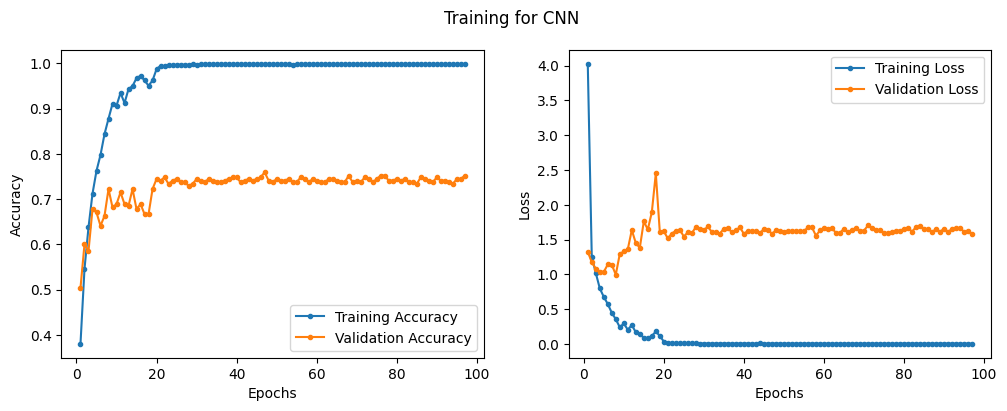

In [30]:
X_test_cnn = np.expand_dims(X_test, 1)
test_data_cnn = torch.utils.data.TensorDataset(torch.tensor(X_test_cnn), torch.tensor(y_test))
test_loader_cnn = torch.utils.data.DataLoader(dataset=test_data_cnn,
                                           batch_size = 16,
                                           shuffle = True)
test_loss_2, test_acc_2 = post_training(trained_model_2, loss_fn, test_loader_cnn, history_model_2, 'CNN')

### LSTM

In [32]:
class LSTM_music(nn.Module):
    def __init__(self):
        super(LSTM_music, self).__init__()
        self.lstm1 = nn.LSTM(input_size=20, hidden_size=128, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=128, hidden_size=256, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(256, 128),
            nn.Dropout(0.5),
            nn.Linear(128, 10)
        )
    
    def forward(self,x):
        out, _ = self.lstm1(x, )
        out = self.lstm2(out)[0][:, -1, :]
        out = self.fc(out)
        return out

In [33]:
model_3 = LSTM_music()
learning_rate = 0.001
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_3.parameters(), lr = learning_rate)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
model_3.to(device)
trained_model_3 , history_model_3 = training(model_3, 'LSTM', loss_fn, optimizer, scheduler, train_loader, valid_loader, 100, 10)

  1%|          | 1/100 [00:03<05:57,  3.61s/it]

Epoch No. 1
Training Accuracy = 0.3128, Loss = 1.8879
Validation Accuracy = 0.4000, Loss = 1.7130


  2%|▏         | 2/100 [00:06<05:35,  3.43s/it]

Epoch No. 2
Training Accuracy = 0.4021, Loss = 1.6320
Validation Accuracy = 0.4333, Loss = 1.5767


  3%|▎         | 3/100 [00:10<05:27,  3.37s/it]

Epoch No. 3
Training Accuracy = 0.4617, Loss = 1.5144
Validation Accuracy = 0.4556, Loss = 1.4653


  4%|▍         | 4/100 [00:13<05:22,  3.36s/it]

Epoch No. 4
Training Accuracy = 0.4992, Loss = 1.4193
Validation Accuracy = 0.4963, Loss = 1.4205


  5%|▌         | 5/100 [00:16<05:18,  3.36s/it]

Epoch No. 5
Training Accuracy = 0.5239, Loss = 1.3516
Validation Accuracy = 0.3593, Loss = 1.7779


  6%|▌         | 6/100 [00:20<05:15,  3.36s/it]

Epoch No. 6
Training Accuracy = 0.5119, Loss = 1.3683
Validation Accuracy = 0.4963, Loss = 1.3904


  7%|▋         | 7/100 [00:23<05:12,  3.36s/it]

Epoch No. 7
Training Accuracy = 0.5407, Loss = 1.3160
Validation Accuracy = 0.5037, Loss = 1.3892


  8%|▊         | 8/100 [00:27<05:10,  3.38s/it]

Epoch No. 8
Training Accuracy = 0.5897, Loss = 1.1854
Validation Accuracy = 0.5259, Loss = 1.3085


  9%|▉         | 9/100 [00:30<05:07,  3.38s/it]

Epoch No. 9
Training Accuracy = 0.5975, Loss = 1.1765
Validation Accuracy = 0.5259, Loss = 1.4815


 10%|█         | 10/100 [00:33<05:04,  3.38s/it]

Epoch No. 10
Training Accuracy = 0.6078, Loss = 1.1076
Validation Accuracy = 0.6111, Loss = 1.1634


 11%|█         | 11/100 [00:37<05:01,  3.38s/it]

Epoch No. 11
Training Accuracy = 0.6428, Loss = 1.0239
Validation Accuracy = 0.6037, Loss = 1.2276


 12%|█▏        | 12/100 [00:40<04:57,  3.38s/it]

Epoch No. 12
Training Accuracy = 0.6951, Loss = 0.8984
Validation Accuracy = 0.5926, Loss = 1.2309


 13%|█▎        | 13/100 [00:43<04:53,  3.37s/it]

Epoch No. 13
Training Accuracy = 0.7074, Loss = 0.8226
Validation Accuracy = 0.5889, Loss = 1.2262


 14%|█▍        | 14/100 [00:47<04:49,  3.37s/it]

Epoch No. 14
Training Accuracy = 0.7160, Loss = 0.8059
Validation Accuracy = 0.6111, Loss = 1.2312


 15%|█▌        | 15/100 [00:50<04:45,  3.36s/it]

Epoch No. 15
Training Accuracy = 0.7543, Loss = 0.7132
Validation Accuracy = 0.5852, Loss = 1.3102


 16%|█▌        | 16/100 [00:53<04:41,  3.35s/it]

Epoch No. 16
Training Accuracy = 0.7675, Loss = 0.6515
Validation Accuracy = 0.6333, Loss = 1.1903


 17%|█▋        | 17/100 [00:57<04:37,  3.35s/it]

Epoch No. 17
Training Accuracy = 0.7860, Loss = 0.6113
Validation Accuracy = 0.6074, Loss = 1.3702


 18%|█▊        | 18/100 [01:00<04:33,  3.34s/it]

Epoch No. 18
Training Accuracy = 0.8193, Loss = 0.5346
Validation Accuracy = 0.6370, Loss = 1.3135


 19%|█▉        | 19/100 [01:03<04:29,  3.33s/it]

Epoch No. 19
Training Accuracy = 0.8140, Loss = 0.5286
Validation Accuracy = 0.6407, Loss = 1.3109


 20%|██        | 20/100 [01:07<04:26,  3.33s/it]

Epoch No. 20
Training Accuracy = 0.8366, Loss = 0.4857
Validation Accuracy = 0.6296, Loss = 1.3088


 21%|██        | 21/100 [01:10<04:22,  3.32s/it]

Epoch No. 21
Training Accuracy = 0.8519, Loss = 0.4362
Validation Accuracy = 0.6333, Loss = 1.3164


 22%|██▏       | 22/100 [01:13<04:18,  3.32s/it]

Epoch No. 22
Training Accuracy = 0.9189, Loss = 0.2552
Validation Accuracy = 0.6556, Loss = 1.3071


 23%|██▎       | 23/100 [01:17<04:15,  3.32s/it]

Epoch No. 23
Training Accuracy = 0.9449, Loss = 0.1921
Validation Accuracy = 0.6593, Loss = 1.3190


 24%|██▍       | 24/100 [01:20<04:12,  3.32s/it]

Epoch No. 24
Training Accuracy = 0.9560, Loss = 0.1571
Validation Accuracy = 0.6593, Loss = 1.3427


 25%|██▌       | 25/100 [01:23<04:08,  3.32s/it]

Epoch No. 25
Training Accuracy = 0.9654, Loss = 0.1314
Validation Accuracy = 0.6741, Loss = 1.3728


 26%|██▌       | 26/100 [01:27<04:05,  3.32s/it]

Epoch No. 26
Training Accuracy = 0.9749, Loss = 0.1117
Validation Accuracy = 0.6630, Loss = 1.4094


 27%|██▋       | 27/100 [01:30<04:02,  3.32s/it]

Epoch No. 27
Training Accuracy = 0.9774, Loss = 0.0960
Validation Accuracy = 0.6667, Loss = 1.4395


 28%|██▊       | 28/100 [01:33<03:59,  3.32s/it]

Epoch No. 28
Training Accuracy = 0.9823, Loss = 0.0816
Validation Accuracy = 0.6667, Loss = 1.4641


 29%|██▉       | 29/100 [01:37<03:56,  3.33s/it]

Epoch No. 29
Training Accuracy = 0.9856, Loss = 0.0711
Validation Accuracy = 0.6667, Loss = 1.5430


 30%|███       | 30/100 [01:40<03:53,  3.33s/it]

Epoch No. 30
Training Accuracy = 0.9881, Loss = 0.0607
Validation Accuracy = 0.6630, Loss = 1.5727


 31%|███       | 31/100 [01:43<03:49,  3.33s/it]

Epoch No. 31
Training Accuracy = 0.9893, Loss = 0.0508
Validation Accuracy = 0.6741, Loss = 1.6076


 32%|███▏      | 32/100 [01:47<03:46,  3.34s/it]

Epoch No. 32
Training Accuracy = 0.9926, Loss = 0.0418
Validation Accuracy = 0.6741, Loss = 1.6433


 33%|███▎      | 33/100 [01:50<03:43,  3.34s/it]

Epoch No. 33
Training Accuracy = 0.9959, Loss = 0.0360
Validation Accuracy = 0.6741, Loss = 1.6511


 34%|███▍      | 34/100 [01:53<03:40,  3.34s/it]

Epoch No. 34
Training Accuracy = 0.9934, Loss = 0.0349
Validation Accuracy = 0.6741, Loss = 1.6477


 34%|███▍      | 34/100 [01:57<03:47,  3.45s/it]

Epoch No. 35
Training Accuracy = 0.9955, Loss = 0.0333
Validation Accuracy = 0.6704, Loss = 1.6509
Early stop at Epoch Number. 35


Loss for test set = 1.8175
Accuracy for test set = 0.6400


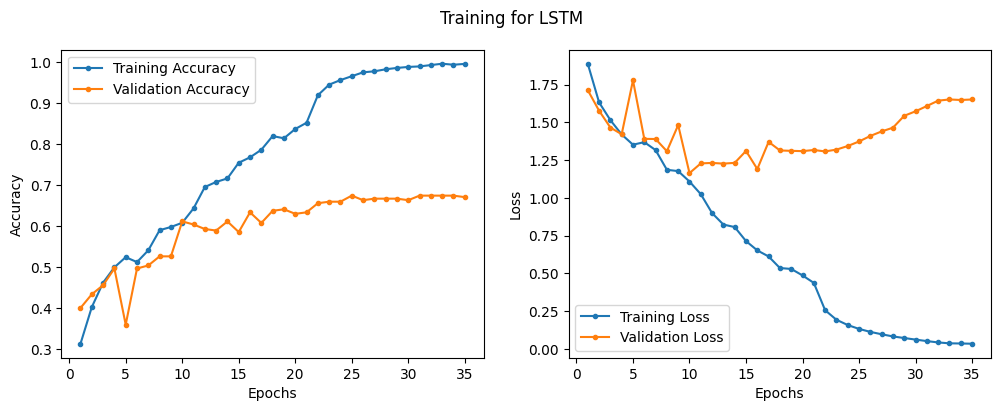

In [34]:
test_loss_3, test_acc_3 = post_training(trained_model_3, loss_fn, test_loader, history_model_3, 'LSTM')